In [1]:
#1 Imports, Seeding & Setup
import os
import random
import time

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import (
    LearningRateScheduler, EarlyStopping, ModelCheckpoint, TensorBoard
)
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import TopKCategoricalAccuracy

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.calibration import calibration_curve


seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

In [2]:
#2 Learning-Rate Schedule
INITIAL_LR = 1e-3

def lr_schedule(epoch):
    return INITIAL_LR * (0.99 ** epoch)

scheduler = LearningRateScheduler(lr_schedule)

In [3]:
#3 Load Data
train = np.load("../data/train.npz")
val   = np.load("../data/val.npz")
test  = np.load("../data/test.npz")

X_train, y_train = train['X'], train['Y']
X_val,   y_val   = val['X'],   val['Y']
X_test,  y_test  = test['X'],  test['Y']

In [4]:
#4 One-Hot Encode Labels
y_train_oh = tf.one_hot(y_train, depth=32)
y_val_oh   = tf.one_hot(y_val,   depth=32)
y_test_oh  = tf.one_hot(y_test,  depth=32)

In [5]:
#5 Sanity-Print Shapes
print("Train:", X_train.shape, y_train.shape)
print("Val:  ",   X_val.shape,   y_val.shape)
print("Test: ",  X_test.shape,  y_test.shape)

Train: (56000, 255) (56000,)
Val:   (12000, 255) (12000,)
Test:  (12000, 255) (12000,)


In [6]:
#6 Build the 6-Hidden-Layer Model
model = models.Sequential([
    layers.Input(shape=(255,), name="input_features"),

    layers.Dense(1024, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-5),
                 name="dense_1"),
    layers.BatchNormalization(name="bn_1"),
    layers.Dropout(0.5, name="dropout_1"),

    layers.Dense(512, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-5),
                 name="dense_2"),
    layers.BatchNormalization(name="bn_2"),
    layers.Dropout(0.5, name="dropout_2"),

    layers.Dense(256, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-5),
                 name="dense_3"),
    layers.BatchNormalization(name="bn_3"),
    layers.Dropout(0.5, name="dropout_3"),

    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-5),
                 name="dense_4"),
    layers.BatchNormalization(name="bn_4"),
    layers.Dropout(0.5, name="dropout_4"),

    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-5),
                 name="dense_5"),
    layers.BatchNormalization(name="bn_5"),
    layers.Dropout(0.5, name="dropout_5"),

    layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(1e-5),
                 name="dense_6"),
    layers.BatchNormalization(name="bn_6"),
    layers.Dropout(0.5, name="dropout_6"),

    layers.Dense(32, activation='softmax', name="output")
])

In [7]:
#7 Compile with Label Smoothing
loss = CategoricalCrossentropy(
    from_logits=False,
    label_smoothing=0.1
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=loss,
    metrics=[
        'accuracy',
        TopKCategoricalAccuracy(k=3, name='top_3_accuracy')
    ]
)

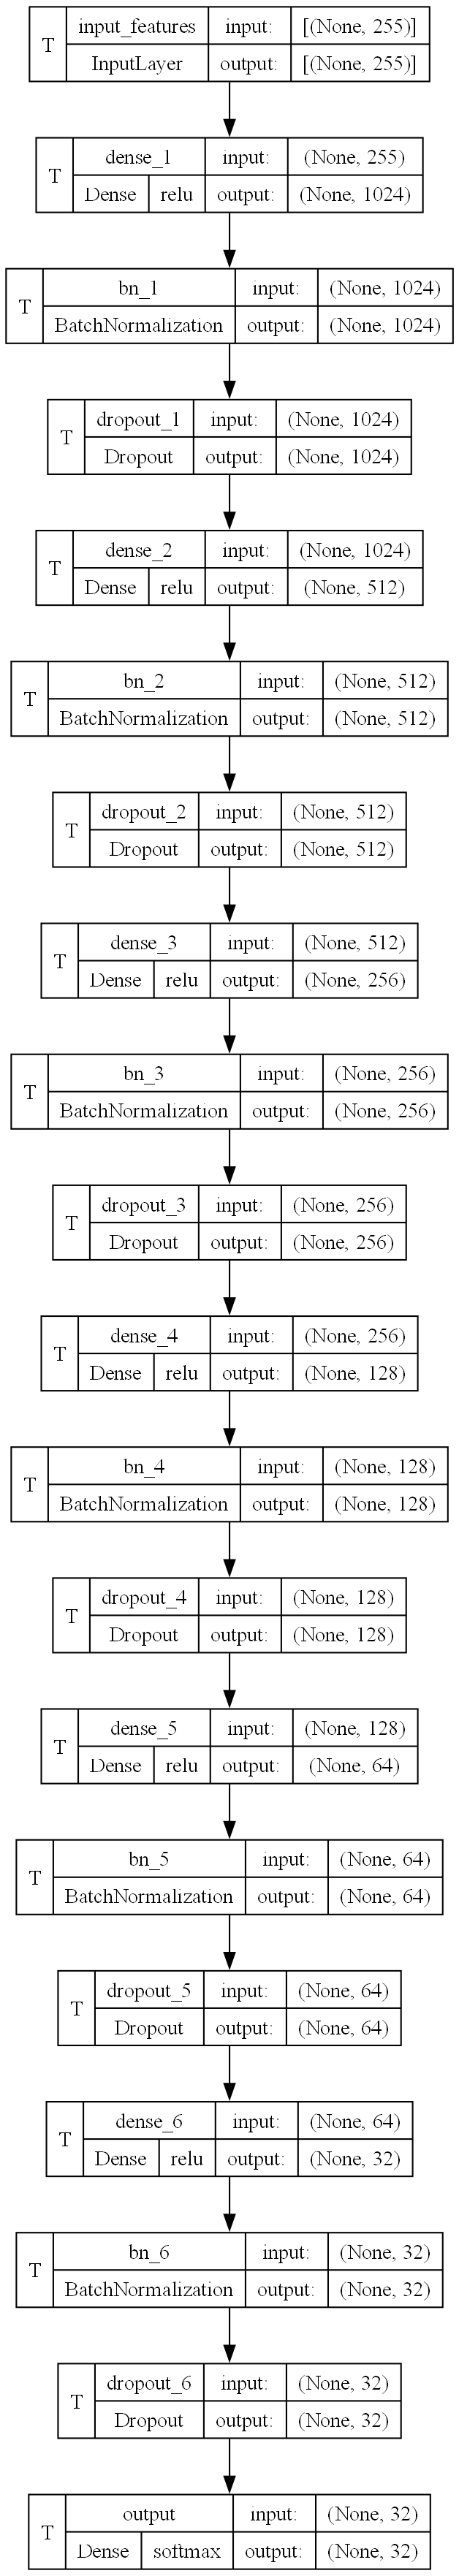

In [26]:
tf.keras.utils.plot_model(
    model,
    to_file="6hl_model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False, dpi=150, show_layer_activations=True, show_trainable=True
)

In [8]:
#9 Train the Model
es   = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
ckpt = ModelCheckpoint(
    "best_six_hl_model.keras",
    save_best_only=True
)
tb = TensorBoard(log_dir="../logs/six_hl")

start = time.time()
history = model.fit(
    X_train, y_train_oh,
    validation_data=(X_val, y_val_oh),
    epochs=30,
    batch_size=64,
    callbacks=[scheduler, es, ckpt, tb]
)
total_time = time.time() - start
time_per_epoch = total_time / len(history.history['loss'])
print(f"Training time: {total_time:.1f}s ≃ {time_per_epoch:.2f}s/epoch")

Epoch 1/30


875/875 [==============================] - 11s 10ms/step - loss: 3.5665 - accuracy: 0.0636 - top_3_accuracy: 0.1676 - val_loss: 2.9397 - val_accuracy: 0.2542 - val_top_3_accuracy: 0.5029 - lr: 0.0010
Epoch 2/30
875/875 [==============================] - 8s 9ms/step - loss: 2.9287 - accuracy: 0.1782 - top_3_accuracy: 0.4131 - val_loss: 2.4491 - val_accuracy: 0.3877 - val_top_3_accuracy: 0.6533 - lr: 9.9000e-04
Epoch 3/30
875/875 [==============================] - 9s 10ms/step - loss: 2.6825 - accuracy: 0.2756 - top_3_accuracy: 0.5531 - val_loss: 2.2460 - val_accuracy: 0.4646 - val_top_3_accuracy: 0.7028 - lr: 9.8010e-04
Epoch 4/30
875/875 [==============================] - 9s 10ms/step - loss: 2.5743 - accuracy: 0.3326 - top_3_accuracy: 0.6051 - val_loss: 2.1427 - val_accuracy: 0.4908 - val_top_3_accuracy: 0.7263 - lr: 9.7030e-04
Epoch 5/30
875/875 [==============================] - 8s 9ms/step - loss: 2.5019 - accuracy: 0.3734 - top_3_accuracy: 0.6317 - val_loss: 2.0812 - 

C:\Users\eltaj\AppData\Local\Temp\ipykernel_4056\3046835315.py:20: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\eltaj\PycharmProjects\EngineSkat\.venv1\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


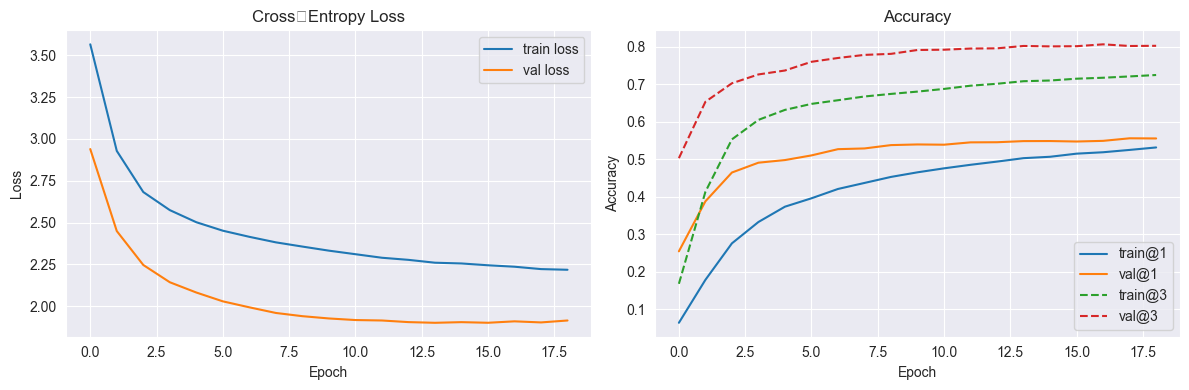

In [9]:
#10 Plot Loss & Accuracy Curves
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'],     label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title("Cross‐Entropy Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'],           label='train@1')
plt.plot(history.history['val_accuracy'],       label='val@1')
plt.plot(history.history['top_3_accuracy'],     '--', label='train@3')
plt.plot(history.history['val_top_3_accuracy'], '--', label='val@3')
plt.title("Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
#11 Final Validation Metrics
val_loss_final = history.history['val_loss'][-1]
val_acc_final  = history.history['val_accuracy'][-1]
val_top3_final = history.history['val_top_3_accuracy'][-1]

print("Val Loss:   ", val_loss_final)
print("Val Acc:    ", val_acc_final)
print("Val Top-3:  ", val_top3_final)

Val Loss:    1.9137400388717651
Val Acc:     0.5554999709129333
Val Top-3:   0.8027499914169312


In [11]:
#12 Test-Set Evaluation
test_loss, test_acc, test_top3 = model.evaluate(
    X_test, y_test_oh,
    batch_size=64, verbose=0
)
print("Test Loss:      ", test_loss)
print("Test Top-1 Acc: ", test_acc)
print("Test Top-3 Acc: ", test_top3)

Test Loss:       1.883771538734436
Test Top-1 Acc:  0.5534999966621399
Test Top-3 Acc:  0.8070833086967468


In [12]:
#13 Regression Metrics on Probabilities
probs    = model.predict(X_test, batch_size=64)
y_onehot = y_test_oh.numpy()

mse = np.mean((probs - y_onehot)**2)
mae = np.mean(np.abs(probs - y_onehot))
print("Test MSE: ", mse)
print("Test MAE: ", mae)

188/188 [==============================] - 1s 3ms/step
Test MSE:  0.016975153
Test MAE:  0.036777068


In [13]:
#14 Train vs. Val Gap
train_acc_final  = history.history['accuracy'][-1]
train_top3_final = history.history['top_3_accuracy'][-1]

gap_acc  = train_acc_final  - val_acc_final
gap_top3 = train_top3_final - val_top3_final

print("Gap Top-1 Acc:", gap_acc)
print("Gap Top-3 Acc:", gap_top3)

Gap Top-1 Acc: -0.02399998903274536
Gap Top-3 Acc: -0.07792854309082031


In [33]:
#15 Save the Model
model.save("six_hidden_layer_model.keras")

In [14]:
#16 Summarize Metrics in a Dict
metrics_6hl = {
    'test_loss':      test_loss,
    'test_acc':       test_acc,
    'test_top3':      test_top3,
    'val_loss':       val_loss_final,
    'val_acc':        val_acc_final,
    'val_top3':       val_top3_final,
    'mse':            mse,
    'mae':            mae,
    'gap_acc':        gap_acc,
    'time_per_epoch': time_per_epoch
}

metrics_6hl

{'test_loss': 1.883771538734436,
 'test_acc': 0.5534999966621399,
 'test_top3': 0.8070833086967468,
 'val_loss': 1.9137400388717651,
 'val_acc': 0.5554999709129333,
 'val_top3': 0.8027499914169312,
 'mse': 0.016975153,
 'mae': 0.036777068,
 'gap_acc': -0.02399998903274536,
 'time_per_epoch': 8.847923943870946}

In [15]:
#17 Shape Sanity Checks
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val   shape:", X_val.shape)
print("y_val   shape:", y_val.shape)
print("X_test  shape:", X_test.shape)
print("y_test  shape:", y_test.shape)

X_train shape: (56000, 255)
y_train shape: (56000,)
X_val   shape: (12000, 255)
y_val   shape: (12000,)
X_test  shape: (12000, 255)
y_test  shape: (12000,)


In [16]:
#18 Inspect First Predictions
preds = model.predict(X_test, batch_size=64).argmax(axis=1)

print("\nFirst 5 X_test rows:\n", X_test[:5])
print("First 5 model predictions:", preds[:5])
print("First 5 ground-truth labels:", y_test[:5])

188/188 [==============================] - 1s 3ms/step

First 5 X_test rows:
 [[0.         1.         0.         ... 0.         0.         0.11666667]
 [0.         0.         0.         ... 0.18333334 0.30833334 0.        ]
 [0.         1.         1.         ... 0.04166667 0.         0.        ]
 [0.         0.         0.         ... 0.         0.19166666 0.36666667]
 [0.         0.         0.         ... 0.11666667 0.31666666 0.20833333]]
First 5 model predictions: [ 1  8 25 17 15]
First 5 ground-truth labels: [30  8 25  4 12]


In [17]:

sample_index = 0
base = X_test[sample_index:sample_index+1].copy()

feature_to_flip = np.random.randint(0, base.shape[1])
modified = base.copy()
modified[0, feature_to_flip] = 1.0 - modified[0, feature_to_flip]

base_probs = model.predict(base, verbose=0)[0]
mod_probs  = model.predict(modified, verbose=0)[0]

print(f"Flipped feature index: {feature_to_flip}")
print("Base top-3 scores:", np.sort(base_probs)[-3:])
print("Mod top-3 scores:",  np.sort(mod_probs)[-3:])
print("Base top-3 indices:",  base_probs.argsort()[-3:][::-1])
print("Mod top-3 indices:",   mod_probs.argsort()[-3:][::-1])

Flipped feature index: 102
Base top-3 scores: [0.06939214 0.13096674 0.20294228]
Mod top-3 scores: [0.06939214 0.13096674 0.20294228]
Base top-3 indices: [1 7 4]
Mod top-3 indices: [1 7 4]


375/375 [==============================] - 1s 2ms/step


C:\Users\eltaj\AppData\Local\Temp\ipykernel_23776\3306088095.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(predictions, residuals, alpha=0.5, cmap='coolwarm', s=10)


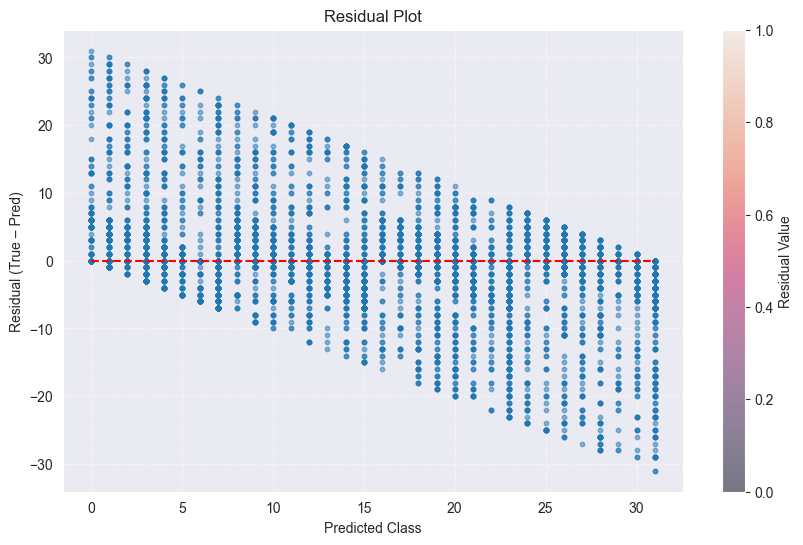

In [18]:
import matplotlib.pyplot as plt
predictions = model.predict(X_test).argmax(axis=1)
residuals   = y_test.flatten() - predictions

plt.figure(figsize=(10,6))
plt.scatter(predictions, residuals, alpha=0.5, cmap='coolwarm', s=10)
plt.hlines(0, xmin=predictions.min(), xmax=predictions.max(),
           colors='r', linestyles='--')
plt.xlabel('Predicted Class')
plt.ylabel('Residual (True – Pred)')
plt.title('Residual Plot')
plt.grid(True, linestyle='--', alpha=0.5)
plt.colorbar(label='Residual Value')
plt.show()

375/375 [==============================] - 1s 2ms/step


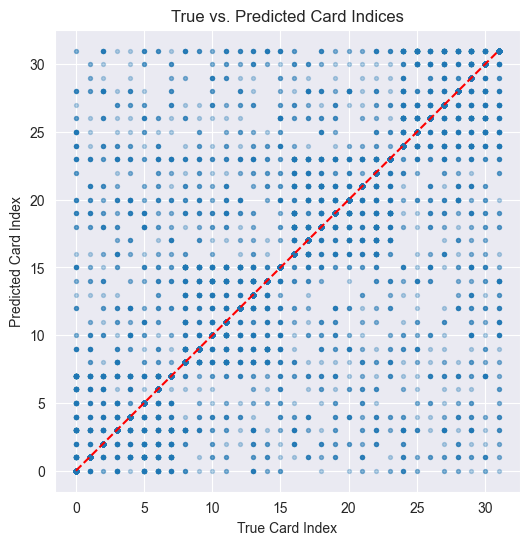

Pearson r between true and predicted labels: 0.758


In [19]:

from scipy.stats import pearsonr

pred_labels = model.predict(X_test).argmax(axis=1)

plt.figure(figsize=(6,6))
plt.scatter(y_test, pred_labels, alpha=0.3, s=8)
plt.plot([0,31],[0,31],'r--')
plt.xlabel("True Card Index")
plt.ylabel("Predicted Card Index")
plt.title("True vs. Predicted Card Indices")
plt.show()

corr, _ = pearsonr(y_test.flatten(), pred_labels)
print(f"Pearson r between true and predicted labels: {corr:.3f}")

375/375 [==============================] - 1s 2ms/step


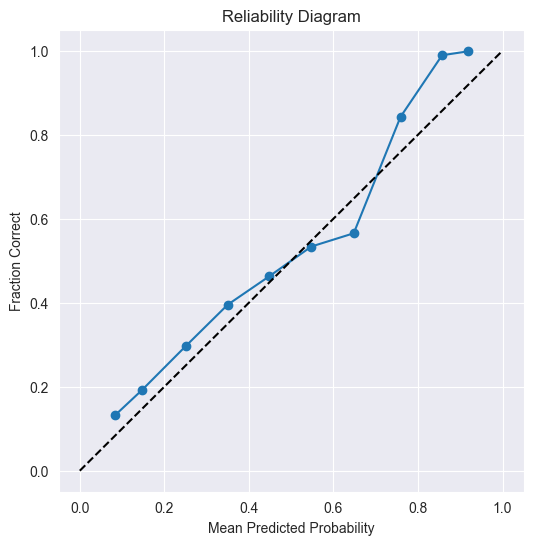

In [20]:

probs_val      = model.predict(X_val)
max_p          = probs_val.max(axis=1)
is_correct_val = (probs_val.argmax(axis=1) == y_val)

frac_pos, mean_pred = calibration_curve(
    is_correct_val, max_p, n_bins=10, strategy='uniform'
)

plt.figure(figsize=(6,6))
plt.plot(mean_pred, frac_pos, marker='o')
plt.plot([0,1],[0,1],'k--')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction Correct")
plt.title("Reliability Diagram")
plt.show()

375/375 [==============================] - 1s 2ms/step


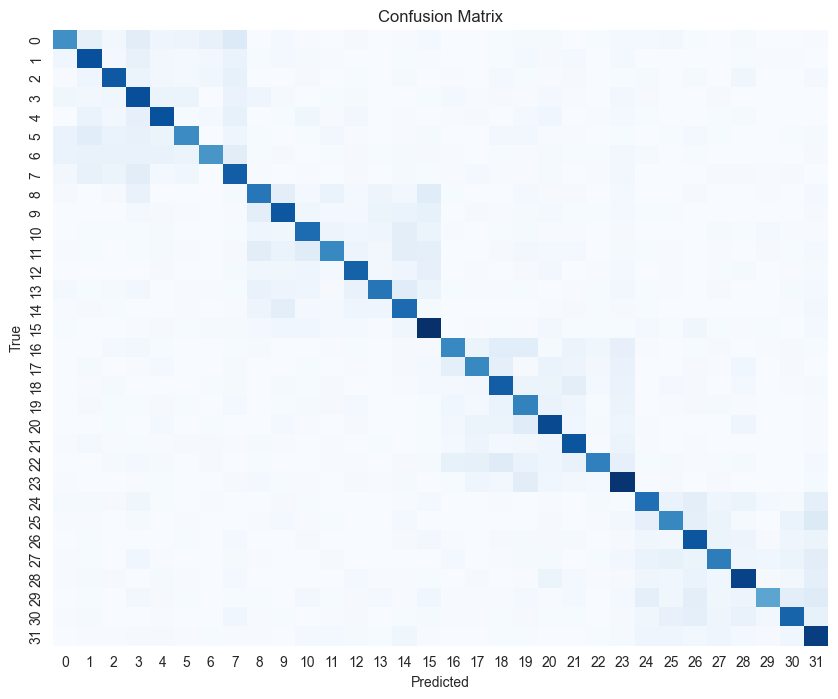

In [21]:

preds = model.predict(X_test).argmax(axis=1)
cm    = confusion_matrix(y_test, preds, labels=range(32))

plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap="Blues", fmt="d", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
